### Ноутбук для создания класса "некачественных фото" для классификатора изображений

In [1]:
import os
import cv2
import numpy as np
import random
import matplotlib.pyplot as plt
from IPython.display import display, clear_output, Javascript
import ipywidgets as widgets
import warnings

In [ ]:
# Директории
base_dir = 'electric_meter'
input_dirs = [os.path.join(base_dir, 'legacy'), os.path.join(base_dir, 'new')]
output_dir = os.path.join(base_dir, 'unusable')
os.makedirs(output_dir, exist_ok=True)

In [ ]:

# Генерация нового случайного итератора каждый раз
image_paths = []
for folder in input_dirs:
    for fname in os.listdir(folder):
        if fname.lower().endswith(('.jpg', '.jpeg', '.png')):
            image_paths.append(os.path.join(folder, fname))

random.shuffle(image_paths)
image_iter = iter(image_paths)

In [ ]:
def apply_natural_darken(img, strength=0.7):
    """Естественное затемнение: понижаем значение 'V' в HSV"""
    hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV).astype(np.float32)
    hsv[..., 2] *= (1.0 - strength)  # уменьшаем яркость
    hsv[..., 2] = np.clip(hsv[..., 2], 0, 255)
    darkened = cv2.cvtColor(hsv.astype(np.uint8), cv2.COLOR_HSV2BGR)
    return darkened


def augment_image(img):
    applied_rus = []
    img_aug = img.copy()

    apply_blur = random.random() < 0.6
    apply_light_or_dark = False

    if apply_blur:
        apply_light_or_dark = random.random() < 0.15
    else:
        apply_light_or_dark = True

    if apply_blur:
        k = random.choice(range(41, 122, 2))
        img_aug = cv2.GaussianBlur(img_aug, (k, k), 0)
        applied_rus.append(f"🔹 Размытие (ядро {k}×{k})")

    if apply_light_or_dark:
        mode = random.choices(['darken', 'brighten'], weights=[0.75, 0.25])[0]
        if mode == 'darken':
            strength = random.uniform(0.75, 0.92)  # насколько темнее
            img_aug = apply_natural_darken(img_aug, strength)
            applied_rus.append(f"Естественное затемнение ({int(strength * 100)}%)")
        else:
            alpha = random.uniform(1.3, 2.2)
            beta = random.randint(30, 90)
            img_aug = cv2.convertScaleAbs(img_aug, alpha=alpha, beta=beta)
            applied_rus.append(f"Засветление (x{round(alpha, 2)}, +{beta})")

    return img_aug, applied_rus



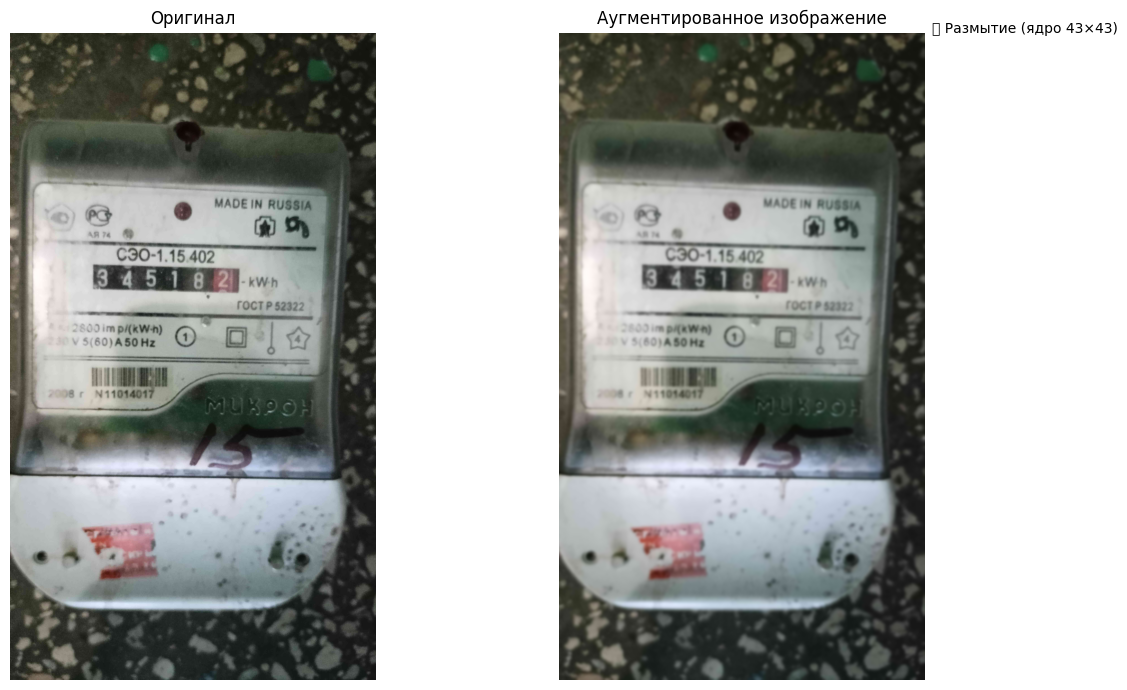

📦 Прогресс: 296/600 сохранено


Button(button_style='success', description='💾 Сохранить', style=ButtonStyle())

In [ ]:
saved_count = len(os.listdir(output_dir))
total_expected = 600

warnings.filterwarnings("ignore")


clear_output(wait=True)

try:
    current_path = next(image_iter)
    img = cv2.imread(current_path)
    fname = os.path.basename(current_path)
    aug_img, aug_rus = augment_image(img)

    fig, ax = plt.subplots(1, 2, figsize=(14, 7))
    ax[0].imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    ax[0].set_title("Оригинал")
    ax[0].axis("off")

    ax[1].imshow(cv2.cvtColor(aug_img, cv2.COLOR_BGR2RGB))
    ax[1].set_title("Аугментированное изображение")
    ax[1].axis("off")

    for i, text in enumerate(aug_rus):
        ax[1].annotate(text, xy=(1.02, 1 - i * 0.08), xycoords='axes fraction',
                       fontsize=10, color='black', backgroundcolor='white')

    plt.tight_layout()
    plt.show()

    print(f"Прогресс: {saved_count}/{total_expected} сохранено")

    def on_save_clicked(b):
        save_path = os.path.join(output_dir, f"unusable_{fname}")
        cv2.imwrite(save_path, aug_img)
        print(f"Сохранено как {save_path}")
        btn_save.close()

    btn_save = widgets.Button(description="Сохранить", button_style='success')
    btn_save.on_click(on_save_clicked)
    display(btn_save)

except StopIteration:
    print("Все изображения просмотрены!")